In [11]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Enable CUDA GPU usage for NVIDIA GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth to avoid allocating all GPU memory at once
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Optionally restrict to specific GPU: tf.config.set_visible_devices(gpus[0], 'GPU')
        print(f"CUDA enabled: {len(gpus)} GPU(s) available")
    except RuntimeError as e:
        print(f"GPU configuration error: {e}")
else:
    print("No GPU found. Training will use CPU.")

# Check available devices
print("\nTensorFlow version:", tf.__version__)
print("Available devices:")
for device in tf.config.list_physical_devices():
    print(f"  - {device}")

# Enable mixed precision training for faster execution on GPU
# Mixed precision (float16) provides significant speedup on NVIDIA GPUs with Tensor Cores
try:
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print(f'\nMixed precision policy: {policy.name}')
except Exception as e:
    print(f'\nMixed precision not available: {e}')

# Enable XLA (Accelerated Linear Algebra) for faster execution on GPU
try:
    tf.config.optimizer.set_jit(True)
    print('XLA compilation enabled')
except Exception as e:
    print(f'XLA not available: {e}')

print('\nGPU optimizations configured (CUDA + mixed precision + XLA)')

No GPU found. Training will use CPU.

TensorFlow version: 2.20.0
Available devices:
  - PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')

Mixed precision policy: mixed_float16
XLA compilation enabled

GPU optimizations configured (CUDA + mixed precision + XLA)


In [14]:
# Define dataset directory paths
dataset_dir = "./archive/"
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Verify paths exist
assert os.path.exists(train_dir), f"Train directory not found: {train_dir}"
assert os.path.exists(test_dir), f"Test directory not found: {test_dir}"

print(f"Dataset train path: {train_dir}")
print(f"Dataset test path: {test_dir}")

Dataset train path: ./archive/train
Dataset test path: ./archive/test


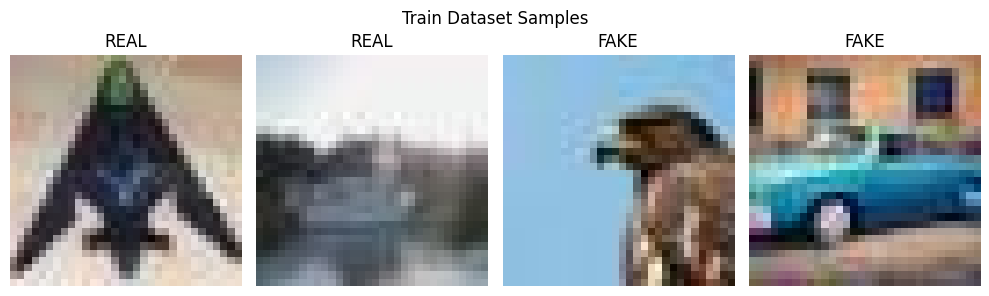

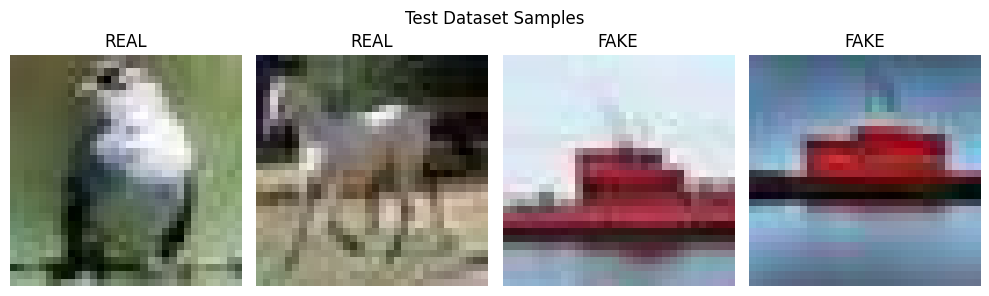

In [15]:
# Display sample images from each class
classes = ['REAL', 'FAKE']

def show_examples(base_dir, title):
    """
    Display sample images from each class in the dataset.
    
    Args:
        base_dir: Base directory containing class subdirectories
        title: Title for the plot
    """
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))
    fig.suptitle(title, fontsize=12)

    for i, cls in enumerate(classes):
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.exists(cls_dir):
            print(f"Warning: Class directory not found: {cls_dir}")
            continue
            
        # Get sample files from each class
        all_files = os.listdir(cls_dir)
        if len(all_files) < 2:
            print(f"Warning: Not enough files in {cls_dir}")
            continue
            
        sample_files = random.sample(all_files, 2)
        for j, img_name in enumerate(sample_files):
            img_path = os.path.join(cls_dir, img_name)
            try:
                img = mpimg.imread(img_path)
                ax = axes[i*2 + j]
                ax.imshow(img)
                ax.set_title(f"{cls}")
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")

    plt.tight_layout()
    plt.show()

# Display examples from train and test datasets
show_examples(train_dir, "Train Dataset Samples")
show_examples(test_dir, "Test Dataset Samples")

In [16]:
# Image preprocessing parameters
img_height = 32
img_width = 32
batch_size = 64 
seed = 42

# Load training data from train folder
full_train_ds = image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=seed,
    label_mode='binary'  # binary classification
)

# Split training data: 90% for training, 10% for validation
total_batches = tf.data.experimental.cardinality(full_train_ds).numpy()
val_batches = int(total_batches * 0.1)
train_batches = total_batches - val_batches

train_ds = full_train_ds.take(train_batches)
val_ds = full_train_ds.skip(train_batches)

# Load test data from test folder (not shuffled or modified)
test_ds = image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    label_mode='binary'
)

# Optimize data pipeline for maximum performance
# AUTOTUNE automatically determines optimal number of parallel calls
AUTOTUNE = tf.data.AUTOTUNE

# Optimize training dataset:
# 1. Cache original images (speeds up subsequent operations)
# 2. Shuffle for randomness
# 3. Augmentation will be applied on-the-fly (in next cell)
# 4. Prefetch to overlap data preprocessing and model execution
train_ds = train_ds.cache()  # Cache original images
train_ds = train_ds.shuffle(buffer_size=1000, seed=seed)  # Shuffle after caching
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch for GPU

# Optimize validation dataset: cache and prefetch
val_ds = val_ds.cache()  # Cache validation data
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch for GPU

# Optimize test dataset: cache and prefetch
test_ds = test_ds.cache()  # Cache test data
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)  # Prefetch for GPU

def count_images(dataset):
    """Count total number of images in a dataset."""
    return sum(batch[0].shape[0] for batch in dataset)

# Count images in each dataset split
train_count = count_images(train_ds)
val_count = count_images(val_ds)
test_count = count_images(test_ds)

# Print dataset summary
print("Dataset Summary:")
print(f"Total batches in train folder: {total_batches}")
print(f"Train batches (90%): {train_batches}")
print(f"Validation batches (10%): {val_batches}")
print(f"\nNumber of images:")
print(f"Train images: {train_count}")
print(f"Validation images: {val_count}")
print(f"Test images: {test_count}")


Found 100000 files belonging to 2 classes.
Found 20000 files belonging to 2 classes.
Dataset Summary:
Total batches in train folder: 1563
Train batches (90%): 1407
Validation batches (10%): 156

Number of images:
Train images: 90048
Validation images: 9952
Test images: 20000


In [17]:
# Data Augmentation (Applied only to training data)
# Augmentation helps improve model generalization by creating variations of training images
# Augmentation is applied on-the-fly (after caching) to ensure variety each epoch
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),  # Randomly flip images horizontally
    layers.RandomRotation(0.1),       # Randomly rotate images up to 10%
    layers.RandomZoom(0.1),           # Randomly zoom images up to 10%
], name='data_augmentation')

# Apply augmentation efficiently using map with parallel processing
# Augmentation is applied on-the-fly (not cached) to ensure variety each epoch
# This way we cache original images but get different augmentations each time
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=AUTOTUNE,  # Parallelize augmentation
    deterministic=False  # Allow non-deterministic order for better performance
)
# Re-prefetch after augmentation to maintain pipeline efficiency
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


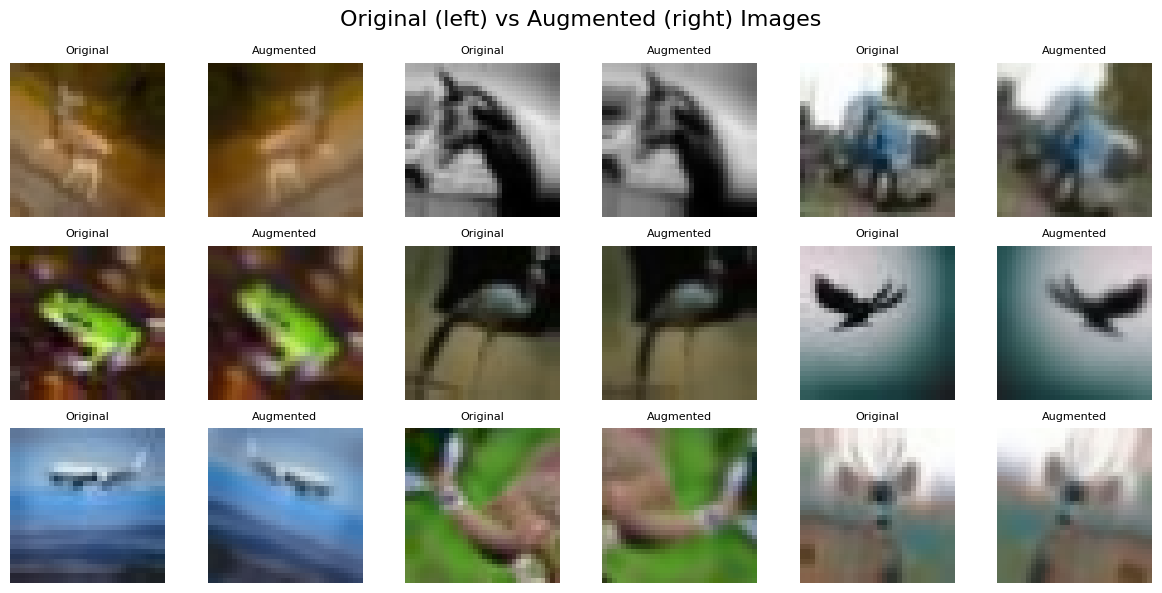

In [18]:
# Visualize original vs augmented images to verify data augmentation is working correctly
for images, labels in train_ds.take(1):
    # Compute augmented batch once
    augmented = data_augmentation(images, training=True)

    plt.figure(figsize=(12, 6))
    for i in range(9):
        # Original image
        plt.subplot(3, 6, 2 * i + 1)
        plt.imshow(tf.cast(images[i], tf.uint8))
        plt.title("Original", fontsize=8)
        plt.axis("off")

        # Augmented image
        plt.subplot(3, 6, 2 * i + 2)
        plt.imshow(tf.cast(augmented[i], tf.uint8))
        plt.title("Augmented", fontsize=8)
        plt.axis("off")

    plt.suptitle("Original (left) vs Augmented (right) Images", fontsize=16)
    plt.tight_layout()
    plt.show()
    break  # Only show one batch

In [ ]:
# Fix SSL certificate verification on macOS (required for Keras weight downloads)
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# ResNet50 ImageNet weights will be downloaded automatically by Keras

In [ ]:
# Load ResNet50 base model with ImageNet pre-trained weights
# Weights are downloaded automatically by Keras
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    pooling='avg'  # Changed to 'avg' for better performance
)

print("ResNet50 base model loaded with weights: imagenet")


ResNet50 base model loaded with weights: ./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [ ]:
# Build the complete model architecture
# Make base model trainable for fine-tuning
base_model.trainable = True

# Define input layer
inputs = tf.keras.Input(shape=(img_height, img_width, 3))

# Pass input through base ResNet50 model
x = base_model(inputs, training=False)

# Add batch normalization for stable training
x = layers.BatchNormalization()(x)

# Add dense layers with regularization to prevent overfitting
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.4)(x)  # Dropout for regularization
x = layers.Dense(64, activation='relu')(x)

# Output layer: single neuron with sigmoid activation for binary classification
# Use float32 for output layer (required for mixed precision)
outputs = layers.Dense(1, activation='sigmoid', dtype='float32')(x)

# Create the complete model
model = tf.keras.Model(inputs, outputs)

# Compile model with optimizer, loss function, and metrics
# Using Adam optimizer with learning rate scheduling
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Binary cross-entropy for binary classification
    metrics=[
        'accuracy',
        tf.keras.metrics.Precision(),  # Precision metric
        tf.keras.metrics.Recall()      # Recall metric
    ]
)

# Display model architecture summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,136,961 (92.08 MB)

 Trainable params: 24,079,745 (91.86 MB)

 Non-trainable params: 57,216 (223.50 KB)

In [ ]:
# Training with callbacks for better performance and convergence

# EarlyStopping: Stop training if validation loss doesn't improve
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',           # Monitor validation loss
    patience=20,                  # Wait 20 epochs before stopping
    restore_best_weights=True,     # Restore weights from best epoch
    verbose=1
)

# ReduceLROnPlateau: Reduce learning rate when validation loss plateaus
# This helps fine-tune the model and improve convergence
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',           # Monitor validation loss
    factor=0.5,                   # Reduce LR by 50%
    patience=5,                   # Wait 5 epochs
    min_lr=1e-7,                  # Minimum learning rate
    verbose=1
)

# ModelCheckpoint: Save best model weights during training
# This ensures we always have the best model even if training continues
os.makedirs('./models', exist_ok=True)
checkpoint_path = './models/best_model_weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',           # Monitor validation loss
    save_best_only=True,          # Only save best model
    save_weights_only=False,     # Save entire model
    verbose=1
)

# Train the model with all callbacks
# Note: train_ds is already shuffled and cached
history = model.fit(
    train_ds,                     # Training dataset (already optimized)
    validation_data=val_ds,       # Validation dataset
    epochs=100,                   # Maximum number of epochs
    callbacks=[early_stop, reduce_lr, model_checkpoint],  # All callbacks
    verbose=1                     # Show training progress
)


Epoch 1/100


2026-02-03 23:17:06.004662: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-03 23:17:27.813041: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 23:17:27.813208: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 23:17:27.813361: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the 

1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7995 - loss: 1.2961 - precision: 0.8028 - recall: 0.7950

2026-02-03 23:19:47.714889: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-03 23:19:48.640609: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1962', 4 bytes spill stores, 4 bytes spill loads

2026-02-03 23:20:00.100699: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.



Epoch 1: val_loss improved from None to 0.40250, saving model to ./models/best_model_weights.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 248s 71ms/step - accuracy: 0.8065 - loss: 0.7070 - precision: 0.8124 - recall: 0.7982 - val_accuracy: 0.8462 - val_loss: 0.4025 - val_precision: 0.8255 - val_recall: 0.8716 - learning_rate: 0.0010
Epoch 2/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8578 - loss: 0.3740 - precision: 0.8563 - recall: 0.8612
Epoch 2: val_loss did not improve from 0.40250
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 75s 53ms/step - accuracy: 0.8589 - loss: 0.3689 - precision: 0.8576 - recall: 0.8615 - val_accuracy: 0.8005 - val_loss: 0.5316 - val_precision: 0.9527 - val_recall: 0.6257 - learning_rate: 0.0010
Epoch 3/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8616 - loss: 0.3532 - precision: 0.8613 - recall: 0.8621
Epoch 3: val_loss did not improve from 0.40250
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - accuracy: 0.8637 - loss: 0.3459 - precision: 0.8614 - recall: 0.8674 - val_accuracy: 0.8472 - val_loss: 0.4093 - val_precision: 0.9699 - val_recall: 0

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 79s 56ms/step - accuracy: 0.9203 - loss: 0.2087 - precision: 0.9241 - recall: 0.9161 - val_accuracy: 0.9283 - val_loss: 0.1820 - val_precision: 0.9344 - val_recall: 0.9187 - learning_rate: 5.0000e-04
Epoch 9/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9255 - loss: 0.1920 - precision: 0.9252 - recall: 0.9254
Epoch 9: val_loss did not improve from 0.18204
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 71s 50ms/step - accuracy: 0.9253 - loss: 0.1952 - precision: 0.9253 - recall: 0.9257 - val_accuracy: 0.9130 - val_loss: 0.2585 - val_precision: 0.9645 - val_recall: 0.8546 - learning_rate: 5.0000e-04
Epoch 10/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9299 - loss: 0.1851 - precision: 0.9311 - recall: 0.9289
Epoch 10: val_loss did not improve from 0.18204
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 49s 34ms/step - accuracy: 0.9322 - loss: 0.1812 - precision: 0.9334 - recall: 0.9310 - val_accuracy: 0.8508 - val_loss: 0.4048 - val_precision: 0.9897 - val_

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 58s 41ms/step - accuracy: 0.9590 - loss: 0.1084 - precision: 0.9584 - recall: 0.9599 - val_accuracy: 0.9377 - val_loss: 0.1757 - val_precision: 0.9826 - val_recall: 0.8891 - learning_rate: 1.2500e-04
Epoch 21/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9602 - loss: 0.1034 - precision: 0.9604 - recall: 0.9598
Epoch 21: val_loss improved from 0.17568 to 0.14891, saving model to ./models/best_model_weights.h5


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 54s 38ms/step - accuracy: 0.9602 - loss: 0.1062 - precision: 0.9610 - recall: 0.9594 - val_accuracy: 0.9446 - val_loss: 0.1489 - val_precision: 0.9767 - val_recall: 0.9091 - learning_rate: 1.2500e-04
Epoch 22/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9620 - loss: 0.1020 - precision: 0.9604 - recall: 0.9641
Epoch 22: val_loss did not improve from 0.14891
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 55s 39ms/step - accuracy: 0.9612 - loss: 0.1027 - precision: 0.9600 - recall: 0.9628 - val_accuracy: 0.9375 - val_loss: 0.1664 - val_precision: 0.9789 - val_recall: 0.8922 - learning_rate: 1.2500e-04
Epoch 23/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9644 - loss: 0.0971 - precision: 0.9641 - recall: 0.9649
Epoch 23: val_loss did not improve from 0.14891
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 46s 33ms/step - accuracy: 0.9631 - loss: 0.0998 - precision: 0.9635 - recall: 0.9628 - val_accuracy: 0.9086 - val_loss: 0.2652 - val_precision: 0.9859 - va

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9741 - loss: 0.0707 - precision: 0.9727 - recall: 0.9759
Epoch 38: val_loss did not improve from 0.14891
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 50s 35ms/step - accuracy: 0.9737 - loss: 0.0713 - precision: 0.9723 - recall: 0.9753 - val_accuracy: 0.9391 - val_loss: 0.1766 - val_precision: 0.9855 - val_recall: 0.8893 - learning_rate: 1.5625e-05
Epoch 39/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9735 - loss: 0.0716 - precision: 0.9730 - recall: 0.9743
Epoch 39: val_loss did not improve from 0.14891
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 47s 33ms/step - accuracy: 0.9741 - loss: 0.0699 - precision: 0.9736 - recall: 0.9748 - val_accuracy: 0.9423 - val_loss: 0.1717 - val_precision: 0.9850 - val_recall: 0.8965 - learning_rate: 1.5625e-05
Epoch 40/100
1406/1407 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.9748 - loss: 0.0689 - precision: 0.9731 - recall: 0.9764
Epoch 40: val_loss did not improve from 0.14891
1407/1407 ━━━━━━━━━━━━━

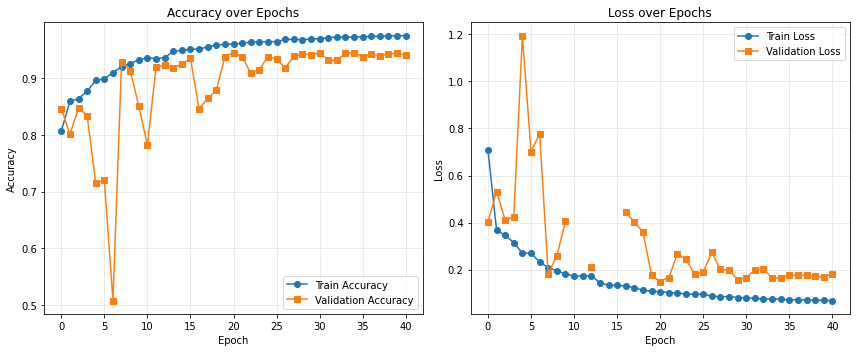

In [ ]:
# Plot training history to visualize model performance
plt.figure(figsize=(12, 5))

# Plot accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")
plt.grid(True, alpha=0.3)

# Plot loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.9422 - loss: 0.1567 - precision: 0.9766 - recall: 0.9061

Test Results:
Test Accuracy: 0.9422
Test Precision: 0.9766
Test Recall: 0.9061


2026-02-03 23:57:23.546980: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2026-02-03 23:57:30.837168: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1923', 116 bytes spill stores, 116 bytes spill loads



313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step


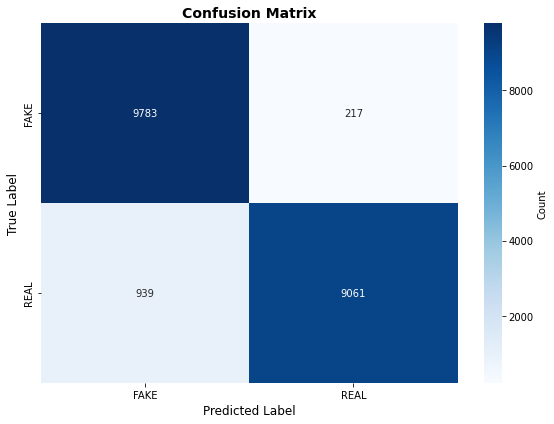


Classification Report:
              precision    recall  f1-score   support

        FAKE       0.91      0.98      0.94     10000
        REAL       0.98      0.91      0.94     10000

    accuracy                           0.94     20000
   macro avg       0.94      0.94      0.94     20000
weighted avg       0.94      0.94      0.94     20000



In [ ]:
# Evaluate model performance on test data
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_ds, verbose=1)
print(f"\nTest Results:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_prec:.4f}")
print(f"Test Recall: {test_rec:.4f}")

# Get true labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Get predictions from model
y_pred = model.predict(test_ds, verbose=1)
# Convert probabilities to binary predictions using 0.5 threshold
y_pred_classes = (y_pred.flatten() > 0.5).astype("int32")

# Create and display confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['FAKE', 'REAL'], 
            yticklabels=['FAKE', 'REAL'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['FAKE', 'REAL']))


In [ ]:
# Save the trained model
os.makedirs('./models', exist_ok=True)
model_save_path = "./models/resnet50_binary.h5"
model.save(model_save_path)
print(f"Model saved successfully to: {model_save_path}")


Model saved successfully to: ./models/resnet50_binary.h5
